In [1]:
import sys
sys.path.append("/users/PCON0003/cond0068/ARA/root6_18_build/lib") # go to parent dir
# sys.path.append("/users/PAS0654/osu8354/ARA/AraRootBuild/lib/") # go to parent dir

from ROOT import TCanvas, TGraph
from ROOT import gROOT
import ROOT
import os
import matplotlib.pyplot as plt
# from TimingCalibration import HistPlotter2D
import numpy as np
# ROOT.gSystem.Load("/users/PCON0003/cond0068/ARA/root6_18_build/lib/libGraf3d.so")
ROOT.gSystem.Load("/users/PCON0003/cond0068/ARA/root6_18_build/lib/libTreePlayer.so")
ROOT.gSystem.Load("/users/PCON0003/cond0068/ARA/root6_18_build/lib/libPostscript.so")
ROOT.gSystem.Load("/users/PCON0003/cond0068/ARA/root6_18_build/lib/libPhysics.so")
ROOT.gSystem.Load("/users/PCON0003/cond0068/ARA/root6_18_build/lib/libROOTDataFrame.so")
ROOT.gSystem.Load("/users/PCON0003/cond0068/ARA/root6_18_build/lib/libMathMore.so")
ROOT.gSystem.Load("/users/PCON0003/cond0068/ARA/root6_18_build/lib/libMinuit.so")
ROOT.gSystem.Load("/users/PCON0003/cond0068/ARA/root6_18_build/lib/libSpectrum.so")
ROOT.gSystem.Load("/users/PCON0003/cond0068/ARA/root6_18_build/lib/libRint.so")

ROOT.gSystem.Load( '%s/lib/libAraEvent.so' % ( os.getenv('HOME') ) )

print('%s/lib/libAraEvent.so'%(os.getenv('HOME')))
print(os.environ['HOME'])
from AutomaticLoadData import LoadDataFromWeb
from TimingCalibration_final import AddOffsets
from TimingCalibration_final import CorrectTimingSample
from TimingCalibration_final import SineFit, SineFunc, invertedFit, reject_outliers

Welcome to JupyROOT 6.18/04
/users/PCON0003/cond0068/lib/libAraEvent.so
/users/PCON0003/cond0068


## Load all variables and define stuff

In [2]:
wf_len = 896
station = 4
channel = 1
rootfile = "2840"
freq = 0.218

#load in data
all_times, volt,blocks = LoadDataFromWeb(station,rootfile,"0118","2018",int(channel),wf_len,0,1,0,0,1)
time = all_times[0]-all_times[0][0]
print('number of events is', np.shape(volt)[0])

num_blocks=len(volt[:,0])#num blocks entries = num events

best_params = np.zeros([num_blocks,4]) #creates a num_blocksx4 array
odds = np.linspace(1,wf_len-1,wf_len/2,dtype=int) #a list containing only odd numbers
evens = np.linspace(0,wf_len-2,wf_len/2,dtype=int)

odd_params=np.zeros([num_blocks,3])
even_params=np.zeros([num_blocks,3])
odd_params2 = np.zeros([num_blocks,3])

odd_half = np.linspace(1,63,32,dtype=int)
even_half= np.linspace(0,62,32,dtype=int)

odd_half2 = np.linspace(65,127,32,dtype=int)

jitter_avg = np.zeros(128)
t_cal = np.zeros(128)

#load all 128 samples into arrays
best_blocks = []
best_freqs = []
jitter_total = []
odd_diffs = []
line_diffs = []

spacing = 0.625#This is the spacing, in ns, between odd/even samples

if(t_cal[5]==0.0):
    print('clearing out old t_cal')
    t_cal=time[:128]
    print(t_cal)

t_cal_full = time
# print('t_cal before is', t_cal_full)

odd_mean = 0.0
even_mean = 0.0

number of events is 1994
clearing out old t_cal
[ 0.      0.3125  0.625   0.9375  1.25    1.5625  1.875   2.1875  2.5
  2.8125  3.125   3.4375  3.75    4.0625  4.375   4.6875  5.      5.3125
  5.625   5.9375  6.25    6.5625  6.875   7.1875  7.5     7.8125  8.125
  8.4375  8.75    9.0625  9.375   9.6875 10.     10.3125 10.625  10.9375
 11.25   11.5625 11.875  12.1875 12.5    12.8125 13.125  13.4375 13.75
 14.0625 14.375  14.6875 15.     15.3125 15.625  15.9375 16.25   16.5625
 16.875  17.1875 17.5    17.8125 18.125  18.4375 18.75   19.0625 19.375
 19.6875 20.     20.3125 20.625  20.9375 21.25   21.5625 21.875  22.1875
 22.5    22.8125 23.125  23.4375 23.75   24.0625 24.375  24.6875 25.
 25.3125 25.625  25.9375 26.25   26.5625 26.875  27.1875 27.5    27.8125
 28.125  28.4375 28.75   29.0625 29.375  29.6875 30.     30.3125 30.625
 30.9375 31.25   31.5625 31.875  32.1875 32.5    32.8125 33.125  33.4375
 33.75   34.0625 34.375  34.6875 35.     35.3125 35.625  35.9375 36.25
 36.5625 36.875  

/apps/python/3.6-conda5.2/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app
/apps/python/3.6-conda5.2/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


## Add offsets

In [ ]:
t_cal_full,odd_mean,even_mean=AddOffsets(t_cal_full,volt,freq,odds,odd_mean,even_mean, channel)

## Fit odd blocks and get fit parameters

In [3]:
for i in range(0,num_blocks):
    odd_params[i,:]=SineFit(t_cal_full[odds],volt[i,odds],freq)

In [4]:
freq_no_outliers = reject_outliers(np.asarray(odd_params[:,0]))
mean_freq = np.mean(freq_no_outliers)
print('mean frequency is', mean_freq)
#histogram([odd_params[:,1],even_params[:,1]],'')

#Scale timing to reflect true frequency
t_cal_full=t_cal_full*mean_freq/freq

mean frequency is 0.21789975878446122


### How does the freq distribution looks like?

Text(0.5,0,'Freq [GHz]')

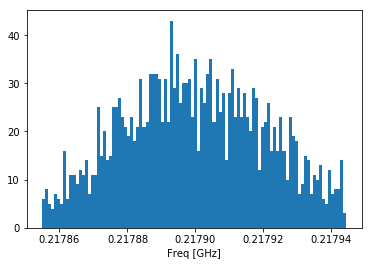

In [5]:
plt.hist(freq_no_outliers,bins=100);
plt.xlabel("Freq [GHz]")

### Re-fit using new timing

In [6]:
np.shape(t_cal_full)

(896,)

loop number  0
mean frequency is 0.21800000002469486


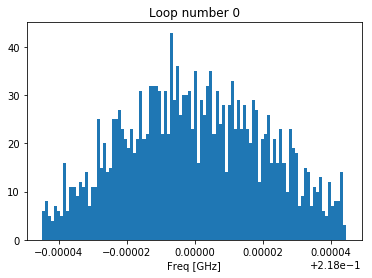

loop number  1
mean frequency is 0.2179896731733963


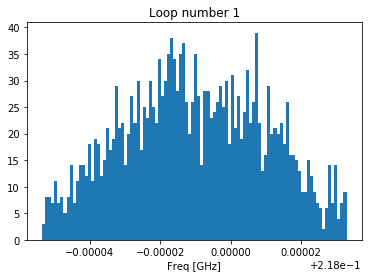

In [7]:
for l in range(0,2): #Perform the fit 5 times, so it converges to the solution
        print('loop number ', l)
        
        for i in range(0,num_blocks):
            odd_params[i,:]=SineFit(t_cal_full[odds],volt[i,odds],freq)

        #histogram([odd_params[:,0],odd_params[:,0]],'')
        freq_no_outliers = reject_outliers(np.asarray(odd_params[:,0]))
        mean_freq = np.mean(freq_no_outliers)
        print('mean frequency is', mean_freq)
        plt.hist(freq_no_outliers,bins=100);
        plt.xlabel("Freq [GHz]")
        plt.title("Loop number %i"%l)
        plt.show()
        #histogram([odd_params[:,1],even_params[:,1]],'')

        #Scale timing to reflect true frequency
        t_cal_full=t_cal_full*mean_freq/freq

        #Re-fit using new time
        for i in range(0,num_blocks):
            odd_params[i,:]=SineFit(t_cal_full[odds],volt[i,odds],freq)


        t_cal = t_cal_full[:128]

        jitter_array = []
        sample_array = []
        slope_array = []
        jitter_slope = []
        new_spacing = np.zeros(128) #spacing between 0 and 1, 1 and 2, etc.
        #Go through each sample and correct based on fit
        for k in range(0,896):
            counter = 0
            for i in range(0,num_blocks):
                if(np.abs(volt[i,k])<30.0 and (freq-odd_params[i,0])<0.002):# and np.abs(odd_params[i,2]>200)):


                    try:
                        invert_fit = invertedFit(odd_params[i,:],t_cal_full[k],volt[i,k])
                        jitter_array.append(invert_fit)
                        sample_array.append(k%128)
                        counter = counter+1
                    except:
                        print('error in finding inverse!')

            t_cal_full[k]=t_cal_full[k]+np.mean(jitter_array[-counter:])
            # print(colored('Sample is %i'%k, 'red'))
            if(k>0):
                new_spacing[k%128]=new_spacing[k%128]+t_cal_full[k]-t_cal_full[k-1]


        new_spacing[1:]=new_spacing[1:]/7.0
        new_spacing[0]=new_spacing[0]/6.0
        #print('spacing is', new_spacing)

        for i in range(0,896):
            if(i==0):
                t_cal_full[i]=0.0
            else:
                t_cal_full[i]=t_cal_full[i-1]+new_spacing[(i)%128]


        #print('final t_cal is',t_cal_full)

        t_cal=t_cal_full[:128]



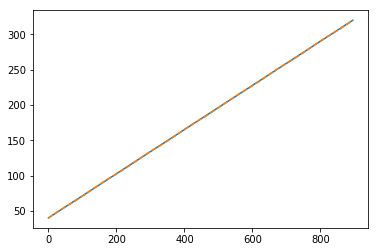

In [15]:
plt.plot(all_times[0])
plt.plot(t_cal_full+all_times[0][0],"--")
# plt.plot(time_cal+all_times[0][0])

In [13]:
time_new = np.load("./SavedCalibData/time_2840_10110.npy")
time_old = np.load("./SavedCalibData/time_2840_10100.npy")

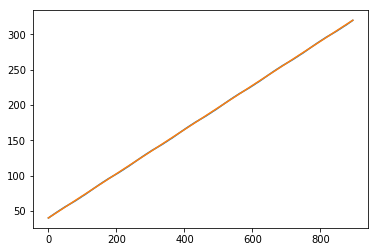

In [26]:
plt.plot(time_new[0]+time_old[0][0])
plt.plot(time_old[0])